In [53]:
import ipywidgets as widgets
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc, ticker
from scipy.stats import norm

%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive

TUdark = (55 / 255, 65 / 255, 74 / 255)
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc("font", **{"family": "serif", "serif": ["Roboto Condensed"]})
rc("text", **{"color": TUdark})
rc("axes", **{"edgecolor": TUdark, "labelcolor": TUdark})
rc("xtick", **{"color": TUdark})
rc("ytick", **{"color": TUdark})

We continue our analysis of the BioNTech/Pfizer [Phase III trial](https://www.nytimes.com/2020/11/18/health/pfizer-covid-vaccine.html). (study protocol [here](https://cdn.pfizer.com/pfizercom/2020-11/C4591001_Clinical_Protocol_Nov2020.pdf)). Here are the four crucial numbers again:

In [6]:
N_t = 22000   # number of people in the treatment arm
N_c = 22000   # number of people in the control arm

m_t = 8   # number of infected people in the treatment arm
m_c = 162 # number of infected people in the control arm

fh_t = m_t / N_t
fh_c = m_c / N_c
print(f'f_hat(treatment): {fh_t:.4e}')
print(f'f_hat(control): {fh_c:.4e}')

f_hat(treatment): 3.6364e-04
f_hat(control): 7.3636e-03


Here is what a **test** for this study would be, and what it would look like:

* The **Null Hypothesis** is: *The probability of infection for people vaccinated with Comirnaty is the same as for unvaccinated people* (i.e. "the vaccine doesn't work"):
$$ p(\text{infection} \mid \text{vaccinated}, \mathcal{H}_0) = p(\text{infection} \mid \neg \text{vaccinated}, \mathcal{H}_0) =: f $$ 
(this is equivalent to Vaccine efficacy being 0%). 
* For the purposes of a test, we want to compute the probability of observing the number of infected people in the treatment arm, or a more extreme (i.e., smaller) number of infections, under the null hypothesis.
* The main challenge here is that we don't know $f$. So we will *marginalise* it out, to get 
$$p(m_t\mid \mathcal{H}_0) = p(m_t\mid f) p(f\mid m_c)\,df$$.

The resulting distribution over the observations is called a *beta-binomial* distribution, which we will introduce now:

Consider again a uniform *Beta* prior (cf. last week's `BioNTech_Confidence.ipynb`):
$$ p(f) = \mathcal{B}(f;1,1) = \frac{1}{B(1,1)}f^0 (1-fx)^0.$$
Remember that this involves the normalization constant, the Beta integral, $B(a,b) = \int_0 ^1 x^{a-1}(1-x)^{b-1}\,dx$ (this will be helpful in a moment).

After observing $m_c = 162$ in the control arm with binomial likelihood
$$ p(m_t\mid f) = \begin{pmatrix} N_c \\ m_c \end{pmatrix} f^{m_c} (1-f)^{N_c - m_c},$$
our posterior over $f$ is 
$$ p(f\mid m_t) = \mathcal{B}(f;m_c + 1, (N_c - m_c) + 1).$$ 
Under the Null Hypothesis, the number of observations $m_t$ in the treatment arm is also binomial distributed. So the predictive distribution for $m_t$ is
\begin{align*}
p(m_t\mid \mathcal{H}_0) &= \int_0 ^1 p(m_t\mid f) p(f\mid m_c)\,df \\
&= \int_0 ^1 \left( \begin{pmatrix} N_t \\ m_t \end{pmatrix} f^{m_t}(1-f)^{N_t-m_t} \right) \left( \frac{1}{B(m_c + 1, (N_c - m_c) + 1} f^{m_c}(1-f)^{N_c-m_c}\,df \right)\\
&= \begin{pmatrix} N_t \\ m_t \end{pmatrix}  \frac{1}{B(m_c + 1, (N_c - m_c) + 1} \int f^{m_t + m_c} (1-f)^{N_c + N_t - m_t - m_c}\,df\\
&=  \begin{pmatrix} N_t \\ m_t \end{pmatrix} \frac{B(m_c + m_t + 1,N_c - m_c + N_t - m_t + 1)}{B(m_c + 1, (N_c - m_c) + 1}
\end{align*}

the p-value is 7.8295e-39


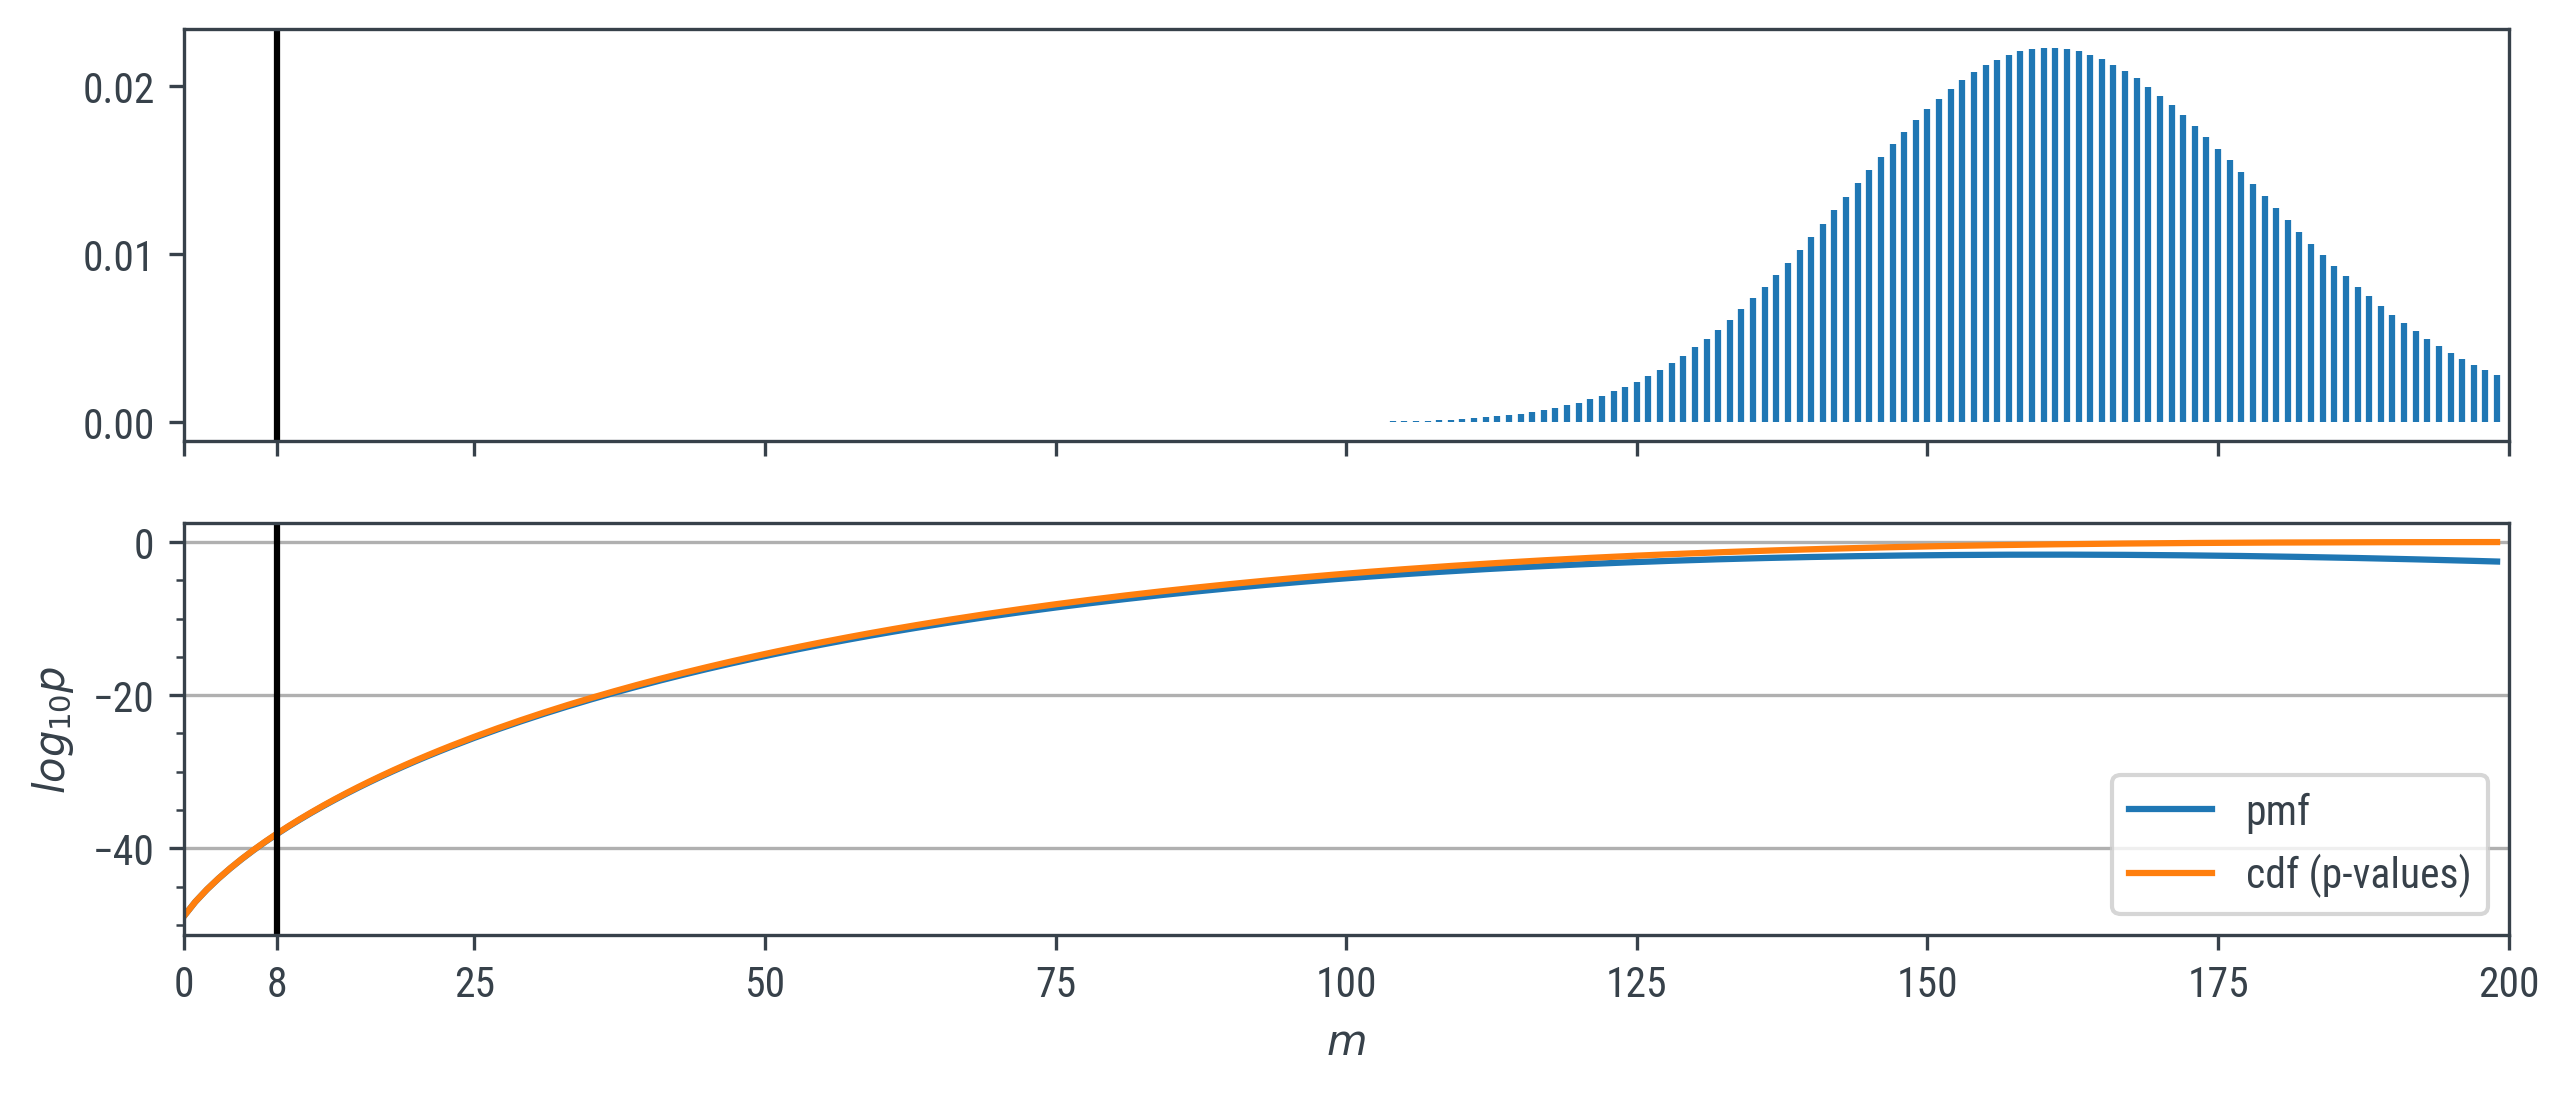

In [15]:
from scipy.stats import betabinom

p = betabinom(N_t,m_c,N_c-m_c)

mm = np.arange(200)

fig,ax = plt.subplots(2,1,sharex=True, figsize=(10, 4),dpi=150)
ax[0].vlines(mm,0,p.pmf(mm))
ax[0].axvline(m_t,color='k')

ax[1].plot(mm,p.logpmf(mm) / np.log(10),label='pmf') # log base 10
ax[1].plot(mm,p.logcdf(mm) / np.log(10),label='cdf (p-values)') # log base 10
ax[1].axvline(m_t,color='k')
ax[1].set_ylabel('$log_{10} p$')
ax[1].set_xlabel('$m$')
ax[1].set_xlim([0,200])
ax[1].set_xticks(list(ax[1].get_xticks()) + [m_t])
ax[1].legend(loc='lower right')
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax[1].grid(which='major',axis='y')

print(f'the p-value is {p.cdf(m_t):.4e}')

If you were the person who had to design the trial, how would you have decided on the size of the cohorts? To answer this question (partially, since we have the advantage of knowing, post-hoc, how well the vaccine works), we can play with the numbers a bit.

In [33]:
from scipy.stats import binom

def plotf(N_control,N_treatment,f_t,f_c):
    f_t /= 1e4  # in units of per 100k people. True value estimated at 3.6364e-04
    f_c /= 1e4  # in units of per 100k people. True value estimated at 7.3636e-03
       
    m_treatment = int(f_t * N_treatment)
    m_control = int(f_c * N_control)
        
    p = betabinom(N_treatment,m_control,N_control-m_control)

    mm = np.arange(200)

    fig,ax = plt.subplots(2,1,sharex=True, figsize=(10, 4),dpi=150)
    ax[0].vlines(mm,0,p.pmf(mm))
    ax[0].vlines(mm,0,binom.pmf(mm,N_treatment,f_t),color='slategray')
    ax[0].axvline(m_treatment,color='k')

    ax[1].plot(mm,p.logpmf(mm) / np.log(10),label='pmf') # log base 10
    ax[1].plot(mm,p.logcdf(mm) / np.log(10),label='cdf (p-values)') # log base 10
    ax[1].axvline(m_treatment,color='k')
    ax[1].set_ylabel('$log_{10} p$')
    ax[1].set_xlabel('$m$')
    ax[1].set_xlim([0,200])
    ax[1].set_xticks(list(ax[1].get_xticks()) + [m_t])
    ax[1].legend(loc='lower right')
    ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax[1].grid(which='major',axis='y')

    # print(f'the p-value is {p.cdf(m_t):.4e}')
    ax[0].set_title(f'the p-value is {p.cdf(m_treatment):.1e}')
    
interactive_plot = interact(
    plotf,
    N_control = widgets.IntSlider(min=int(1e3),max=int(5e4),step=1000,value=N_c),
    N_treatment = widgets.IntSlider(min=int(1e3),max=int(5e4),step=1000,value=N_c),
    f_t = widgets.FloatSlider(min=1,max=100,value=4,step=1),
    f_c = widgets.FloatSlider(min=1,max=100,value=73,step=1),
)
interactive_plot

interactive(children=(IntSlider(value=22000, description='N_control', max=50000, min=1000, step=1000), IntSlid…

<function __main__.plotf(N_control, N_treatment, f_t, f_c)>

So the $p$-value is *very* small indeed. **The Null Hypothesis is rejected at the $7.8 \cdot 10^{-39}$ level**. Note, also, that it is a bit tricky to define clearly what a *two-tailed* version of this test would look like.

## Designing tests: Receiver-Operator Characteristics ("ROC curves")

Now, as added complication, let's imagine we were the *regulator* (e.g. the EMA, not the company), and had to decide what kind of trial results we consider convincing. For simplicity, let's say we know the "background" rate $p(\text{infection}\mid \neg\text{vaccinated})$ (the more general version is actually not that hard, but more confusing). Imagine you are the manager at Pfizer making the call about how large the treatment group should be. Note the following observations:

* Each experiment costs money. So we would like to keep $N_t$ small.
* If the effect is large (VE close to 100%), then it will be possible to detect the effect even with a relatively small cohort $N_t$. But if the effect is small (VE close to 0), the $p$-value will be very small. 
* Another way of thinking about this is that, if we insist on making a decision "accept vaccine candidate" or "reject vaccine candidate" **for a particular value $N_t$**, then the probability of that decision being wrong increases with falling $N_t$.

The **Receiver Operating Characteristic (ROC) curve** maps the TPR vs.~the FPR of a binary classifier

In [34]:
from scipy.stats import binom

f0 = m_c / N_c  # the background rate (assumed known for simplicity. Otherwise, use betabinom, but that might just be confusing. Try it yourself if you like, though!)
print(f'the background rate is {f0 * 1e3:.1f} per thousand')

def plot(n,f1,threshold):
    r0 = binom(n, f0)
    r1 = binom(n, f1 / 1e3)
    
    x = np.arange(np.minimum(r0.ppf(0.001),r1.ppf(0.001)),np.maximum(r0.ppf(0.999),r1.ppf(0.999)))
    
    fig,ax = plt.subplots(1,2,figsize=(10,3),dpi=150)
    ax[0].vlines(x, 0, r0.pmf(x), colors="slategray", label="$H_0$")
    ax[0].vlines(x, 0, r1.pmf(x), colors="firebrick", label="$H_1$")
    ax[0].axvline(threshold,color='k')
    ax[0].legend(loc='upper left')
    ax[0].set_xlabel('m')
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator())
    ax[0].set_title('predicted observations')
    
    TPR = r1.cdf(x)  # true positive rate
    FPR = r0.cdf(x)  # false positive rate

    ax[1].plot(
        FPR, TPR, ".-", color="steelblue",markersize=5,linewidth=2
    )
    ax[1].plot(r0.cdf(threshold),r1.cdf(threshold),'o',mfc='darkorange')
    ax[1].vlines(r0.cdf(threshold),0,r1.cdf(threshold),lw=1,color='darkorange')
    ax[1].hlines(r1.cdf(threshold),0,r0.cdf(threshold),lw=1,color='darkorange')
    
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC')
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(.1))
    ax[1].yaxis.set_major_locator(ticker.MultipleLocator(.1))
    ax[1].grid(axis='both')
    ax[1].set_xlim(-0.05,1.05)
    ax[1].set_ylim(-0.05,1.05)
    
# some jupyter foo:
n_widget = widgets.IntSlider(min=1000, max=int(1e4), step=int(1e3), value=1000)
t_widget = widgets.IntSlider(min=1,max=10,step=1)

def update_t_range(*args):
    t_widget.max = int(10 * n_widget.value/1000)
n_widget.observe(update_t_range, 'value')
    
interactive_plot = interactive(
    plot,
    n= n_widget,
    f1 = widgets.FloatSlider(min=1,max=f0 * 1e3,step=1,value=1),
    threshold = t_widget
)
interactive_plot

the background rate is 7.4 per thousand


interactive(children=(IntSlider(value=1000, description='n', max=10000, min=1000, step=1000), FloatSlider(valu…